# Sentinel 3 - OLCI Data Download

This notebook presents the tools for the data access and download of Sentinel-3 A/B data OLCI images using the WEkEO API.

## 1. Define Workspace

In [18]:
import base64
import os
import shutil
from dotenv import load_dotenv
load_dotenv()

# API requests config
import requests

# Widgets and maps view
# from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as wg
# from IPython.display import display

In [19]:
cwd = {
    'S3_images': './in/satellite_imagery/S3',
    'simile_lakes': './vector/simile_laghi'
}   

## 2. Setup HDA Client

For setting up the credentials for the HDA API, you must edit the `./notebooks/.env` file with you WEkEO user. It is possible to create a user account in the [WEkEO](https://www.wekeo.eu/) platform by going to the **Register** option and complitening the form to create an account

In [20]:
# Import the credentials from the configuration file in the notebooks directory
url = os.environ['HDA_URL']
user = os.environ['HDA_USER']
password = os.environ['HDA_PASSWORD']

In [21]:
credentials = user+": "+password
credentials_bytes = credentials.encode('ascii')
base64_bytes = base64.b64encode(credentials_bytes)
base64_credentials = base64_bytes.decode('ascii')

Create a string of a call to **GET** /gettoken to get a token. Execute it with os.popen in order to store output as variable

In [22]:
header = {'authorization' : 'Basic '+base64_credentials}
response = requests.get(url+'/gettoken', headers=header)
response = response.json()

Before data can be accessed, the Copernicus Terms and Conditions must be accepted. This needs to be done only once.

In [23]:
header = {
    'accept': 'application/json',
    'authorization' : response['access_token']
}
requests.put(url+'/termsaccepted/Copernicus_General_License', headers=header)

<Response [200]>

In [24]:
parameters = 'url: '+url+'\nuser: '+user+'\npassword: '+password+'\ntoken: '+response['access_token']

In [25]:
# Creation of the client .hdarc config file in the $HOME direcotry used by the hda API library. It is sufficient to run this step once.
with open(os.path.join(os.environ['HOME'],'.hdarc'), 'w') as fp:
    fp.write(parameters)

## 3. Request Sentinel-3 A/B images

In this section, we will review the parameters for the composition of a new request of the satellite images using the [hda API](https://www.wekeo.eu/docs/harmonised-data-access-api).

In [26]:
from hda import Client

In [27]:
#Avoid printing secrets
c = Client()

In [28]:
# Import necessary libraries for the project

# Data
import pandas as pd
import geopandas as gpd

# Plotting
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

Import the reference layer for determining the bound of the query. In this case, it corresponds to the lakes extent.

In [29]:
gdf = gpd.read_file(os.path.join(cwd['simile_lakes'],'simile_laghi.shp'))

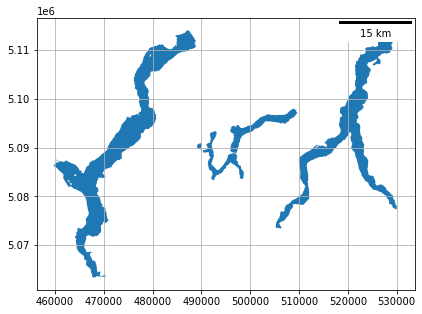

In [30]:
fig, ax = plt.subplots(figsize=(25, 5))
# Plot lakes vector dataset
gdf.plot(ax=ax)
ax.grid()
# Create scale bar
scalebar = ScaleBar(0.001, "km", length_fraction=0.25)
ax.add_artist(scalebar)

In [31]:
# It is necessary to have the query coordinates in web mercator
gdf = gdf.to_crs("EPSG:4326")
# Extract the information from the bounding box of the layer
x_min = min(gdf.bounds['minx'])
x_max = min(gdf.bounds['maxx'])
y_min = min(gdf.bounds['miny'])
y_max = min(gdf.bounds['maxy'])

Define the dictionary with the parameters for the file to import. In this case, the image download refer to the *"OLCI Level 1B Full Resolution - Sentinel-3"* products available through the API. To find more information about the avaliable datasets in the platform you are welcome to visit the [WEkEO data viewer](https://www.wekeo.eu/data?view=viewer). Make sure to specify the dates of interest for the processing.

In [34]:
query = {
  "datasetId": "EO:EUM:DAT:SENTINEL-3:OL_1_EFR___",
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [
        x_min,
        y_min,
        x_max,
        y_max
      ]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": "2022-09-01T00:00:00.000Z",
      "end": "2022-09-26T00:00:00.000Z"
    }
  ],
  "stringChoiceValues": [
    {
      "name": "platformname",
      "value": "Sentinel-3"
    },
    {
      "name": "producttype",
      "value": "OL_1_EFR___"
    },
    {
      "name": "timeliness",
      "value": "Non Time Critical"
    }
  ]
}

In [35]:
# The following line runs the query
matches = c.search(query)

# The following line prints the products returned by the query
print(matches)

SearchResults[items=35,volume=22.8G,jobId=F-h40SbXHwLwYeSJPCXHwKpJ0o4]


In [36]:
#The download starts. All the products found in the query are downloaded consecutively
matches.download()

2022-09-27 10:13:08,550 INFO Downloading https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/mpuD5fLlTxZOrdiDpRWwJkANpD0 to S3B_OL_1_EFR____20220925T095625_20220925T095925_20220926T150729_0180_071_022_2160_MAR_O_NT_002 (691.1M)
/root/miniconda3/envs/snapEnv/lib/python3.6/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eumetsat.dpi.wekeo.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
2022-09-27 10:15:36,501 INFO Download rate 4.7M/s  
2022-09-27 10:15:52,207 INFO Downloading https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/AqnwnSJOoqFVdZkbsIqPIDFUNPE to S3A_OL_1_EFR____20220924T092049_20220924T092349_20220925T134950_0179_090_150_2160_MAR_O_NT_002 (651.8M)
/root/miniconda3/envs/snapEnv/lib/python3.6/site-packages/urllib3/connectionpool.py:1052: Insecu

HTTPError: 403 Client Error: FORBIDDEN for url: https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder

In [37]:
for product in matches.__dict__['results']:
    shutil.move(product['filename'], cwd['S3_images'])

FileNotFoundError: [Errno 2] No such file or directory: 'S3B_OL_1_EFR____20220910T094515_20220910T094815_20220911T150215_0179_070_193_2160_MAR_O_NT_002'

In [38]:
import zipfile
for root, dirs, files in os.walk(cwd['S3_images']):
    for zip_name in files:
        with zipfile.ZipFile(os.path.join(root,zip_name), 'r') as zip_ref:
            zip_ref.extractall(cwd['S3_images'])
        os.remove(os.path.join(root,zip_name))

BadZipFile: File is not a zip file